In [128]:
import torch
from torch import nn
import math
import numpy as np

In [129]:
SEED = 42
LOOKBACK = 30
FORECAST = 7
BATCH_SIZE = 64

torch.random.manual_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [130]:
class Embedding(nn.Module):
    def __init__(self, num_features, d_model=512):
        super(Embedding, self).__init__()
        self.linear = nn.Linear(num_features, d_model)

    def forward(self, x):
        x = self.linear(x)
        return x

In [131]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model=512, max_len=5000):
        super(PositionalEncoding, self).__init__()
        encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        encoding = encoding.unsqueeze(0)

        # Register the encoding as a buffer so it is not a model parameter
        self.register_buffer('encoding', encoding)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]

In [132]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=512, num_heads=8, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.drop = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q的形状: [batch_size, num_heads, seq_len, d_k]
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # 如果提供了mask，则将其应用于注意力分数
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
            
        # 应用softmax获取注意力权重
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.drop(attn_weights)
        
        # 应用注意力权重到值(V)
        output = torch.matmul(attn_weights, V)
        
        return output
    
    def split_heads(self, x):
        # 输入x的形状: [batch_size, seq_len, d_model]
        batch_size, seq_len = x.size(0), x.size(1)
        
        # 重塑为 [batch_size, seq_len, num_heads, d_k]
        x = x.view(batch_size, seq_len, self.num_heads, self.d_k)
        
        # 转置为 [batch_size, num_heads, seq_len, d_k]
        return x.transpose(1, 2)
    
    def combine_heads(self, x):
        # 输入x的形状: [batch_size, num_heads, seq_len, d_k]
        batch_size, _, seq_len = x.size(0), x.size(1), x.size(2)
        
        # 转置回 [batch_size, seq_len, num_heads, d_k]
        x = x.transpose(1, 2)
        
        # 重塑为 [batch_size, seq_len, d_model]
        return x.contiguous().view(batch_size, seq_len, self.d_model)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # 线性变换
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # 分割头
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        # 应用缩放点积注意力
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # 合并头
        output = self.combine_heads(attn_output)
        
        # 最终线性变换
        output = self.W_o(output)
        
        return output

In [133]:
class FeedForward(nn.Module):
    def __init__(self, d_model=512, d_ff=2048):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [134]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.self_attn(x, x, x)
        x = self.drop(x)
        x = self.norm1(x + residual)
        
        residual = x
        x = self.feed_forward(x)
        x = self.drop(x)
        x = self.norm2(x + residual)
        
        return x

In [135]:
class Encoder(nn.Module):
    def __init__(self, num_feature,num_layers=6, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = Embedding(num_feature,d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.drop(x)

        for layer in self.layers:
            x = layer(x)
        
        return x

In [136]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm3 = nn.LayerNorm(d_model)

        self.drop = nn.Dropout(dropout)

    def forward(self, x, encode_ouput, mask):
        residual = x
        x = self.self_attn(x, x, x, mask)
        x = self.drop(x)
        x = self.norm1(x + residual)
        
        residual = x
        x = self.enc_dec_attn(x, encode_ouput, encode_ouput)
        x = self.drop(x)
        x = self.norm2(x + residual)
        
        residual = x
        x = self.feed_forward(x)
        x = self.drop(x)
        x = self.norm3(x + residual)
        
        return x

In [137]:
class Decoder(nn.Module):
    def __init__(self, num_feature,num_layers=6, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = Embedding(num_feature,d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(d_model, num_feature)
        
        self.drop = nn.Dropout(dropout)

    def forward(self, x, enc_output, mask):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.drop(x)

        for layer in self.layers:
            x = layer(x, enc_output, mask)

        x = self.fc(x)
        
        return x

In [138]:
def create_look_ahead_mask(size):
    mask = torch.triu(torch.ones(size, size), diagonal=1).type(torch.uint8)
    return mask == 0

In [139]:
def infer(encoder, decoder, inputs, infer_steps):
    """
    inputs: [1, seq_len, num_features]
    results: [infer_steps, num_features]
    """
    encoder.eval()
    decoder.eval()

    results = []

    with torch.no_grad():
        shift_outputs = inputs[:, -1:, :]

        encode = encoder(inputs)
        for _ in range(infer_steps):
            mask_size = shift_outputs.size(1)
            mask = create_look_ahead_mask(mask_size)

            decode = decoder(shift_outputs, encode, mask)

            results.append(decode[:, -1, :])

            shift_outputs = torch.cat((shift_outputs, decode[:, -1, :].unsqueeze(1)), dim=1)

    return torch.cat(results, dim=0)

In [140]:
def prepare_data(data, lookback, forecast):
    X, y = [], []
    for i in range(len(data) - lookback - forecast + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+forecast])
    return np.array(X), np.array(y)

In [141]:
def fetch_data_loader():
    import baostock as bs
    import pandas as pd
    
    bs.login()
    rs = bs.query_history_k_data_plus("sh.600000",
        "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST",
        start_date='2020-01-01', end_date='2023-12-31',
        frequency="d", adjustflag="3")
    data_list = []
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    df = pd.DataFrame(data_list, columns=rs.fields)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df = df.reset_index(drop=True)
    df = df[['open', 'high', 'low', 'close', 'volume', 'amount', 'turn', 'pctChg']]
    df = df.astype(float)

    print(df.head())

    bs.logout()

    # 对数变换
    from sklearn.model_selection import train_test_split
    from torch.utils.data import DataLoader, TensorDataset

    data = df.values

    # 对价格和成交量应用对数变换
    # 注意：pctChg已经是百分比变化，不需要变换
    price_columns = [0, 1, 2, 3]  # open, high, low, close
    volume_columns = [4, 5]  # volume, amount
    
    # 应用对数变换（加上一个小常数避免log(0)）
    data[:, price_columns] = np.log(data[:, price_columns] + 1e-8)
    data[:, volume_columns] = np.log(data[:, volume_columns] + 1e-8)

    X, y = prepare_data(data, LOOKBACK, FORECAST)
    
    # 先划分训练集和验证集
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=False)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader

In [142]:
def train(encoder, decoder, train_loader, val_loader, lr, epochs=20, patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder.to(device)
    decoder.to(device)

    criterion = nn.MSELoss()
    params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(params, lr=lr)
    
    # 早停机制相关变量
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = {
        'encoder': None,
        'decoder': None,
        'epoch': -1,
        'val_loss': float('inf')
    }

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        total_loss = 0

        for train_x, train_y in train_loader:
            train_x, train_y = train_x.to(device), train_y.to(device)

            optimizer.zero_grad()

            enc_output = encoder(train_x)

            mask_size = train_y.size(1)
            mask = create_look_ahead_mask(mask_size).to(device)

            decoder_input = torch.cat([train_x[:, -1:, :], train_y[:, :-1, :]], dim=1)

            dec_output = decoder(decoder_input, enc_output, mask)

            loss = criterion(dec_output, train_y)
            loss.backward()

            # 添加梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
            
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

        # Validation
        encoder.eval()
        decoder.eval()
        val_loss = 0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x, val_y = val_x.to(device), val_y.to(device)

                enc_output = encoder(val_x)

                mask_size = val_y.size(1)
                mask = create_look_ahead_mask(mask_size).to(device)

                decoder_input = torch.cat([val_x[:, -1:, :], val_y[:, :-1, :]], dim=1)

                dec_output = decoder(decoder_input, enc_output, mask)

                loss = criterion(dec_output, val_y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        
        # 早停机制检查
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # 保存最佳模型状态
            best_model_state = {
                'encoder': encoder.state_dict().copy(),
                'decoder': decoder.state_dict().copy(),
                'epoch': epoch,
                'val_loss': avg_val_loss
            }
            print(f"Validation loss improved to {avg_val_loss:.4f}, saving model...")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
            
        # 检查是否应该早停
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.4f}")
            # 恢复最佳模型
            encoder.load_state_dict(best_model_state['encoder'])
            decoder.load_state_dict(best_model_state['decoder'])
            break
    
    # 如果没有早停，确保最后保存的是最佳模型
    if patience_counter < patience:
        encoder.load_state_dict(best_model_state['encoder'])
        decoder.load_state_dict(best_model_state['decoder'])
        print(f"Training completed. Best validation loss: {best_val_loss:.4f} at epoch {best_model_state['epoch']+1}")

In [ ]:
# 获取数据
train_loader, val_loader = fetch_data_loader()

# 获取特征数量
num_features = train_loader.dataset[0][0].shape[-1]

# 初始化模型
encoder = Encoder(num_features)
decoder = Decoder(num_features)

# 训练模型
train(encoder, decoder, train_loader, val_loader, lr=0.0001, epochs=50000)

# 示例推理
# 获取一个样本进行推理
sample_input, sample_output = val_loader.dataset[0]
sample_input = sample_input.unsqueeze(0)  # 添加批次维度

predictions = infer(encoder, decoder, sample_input, FORECAST)

# 反对数变换
# 对价格和成交量应用对数变换
# 注意：pctChg已经是百分比变化，不需要变换
price_columns = [0, 1, 2, 3]  # open, high, low, close
volume_columns = [4, 5]  # volume, amount

predictions = predictions.cpu().numpy()
sample_output = sample_output.numpy()

# 应用对数变换（加上一个小常数避免log(0)）
predictions[:, price_columns] = np.exp(predictions[:, price_columns]) - 1e-8
predictions[:, volume_columns] = np.exp(predictions[:, volume_columns]) - 1e-8
sample_output[:, price_columns] = np.exp(sample_output[:, price_columns]) - 1e-8
sample_output[:, volume_columns] = np.exp(sample_output[:, volume_columns]) - 1e-8



print("Predictions:", predictions)

login success!
    open   high    low  close      volume       amount    turn  pctChg
0  12.47  12.64  12.45  12.47  51629079.0  647446166.0  0.1837  0.8084
1  12.57  12.63  12.47  12.60  38018810.0  477053357.0  0.1353  1.0425
2  12.52  12.65  12.42  12.46  41001193.0  514432551.0  0.1459 -1.1111
3  12.51  12.60  12.46  12.50  28421482.0  355811756.0  0.1011  0.3210
4  12.41  12.45  12.25  12.32  35240536.0  434980266.0  0.1254 -1.4400
logout success!
Epoch [1/1], Loss: 31.6154
Validation Loss: 18.9353
Validation loss improved to 18.9353, saving model...
Training completed. Best validation loss: 18.9353 at epoch 1
Predictions: [[ 2.8222730e+00  3.2694998e+00  3.6168275e+00  4.0104213e+00
   7.3096714e+03  2.3504654e+04  6.9785066e-02 -3.5313796e-02]
 [ 2.8098357e+00  3.2604063e+00  3.6108863e+00  3.9727707e+00
   7.3339150e+03  2.3442846e+04  7.2131075e-02 -4.3859873e-02]
 [ 2.8089423e+00  3.2611632e+00  3.6067235e+00  3.9652395e+00
   7.3289292e+03  2.3467834e+04  7.1918271e-02 -4.58

In [144]:
# 'open', 'high', 'low', 'close', 'volume', 'amount', 'turn', 'pctChg'
print(predictions.shape)  # 应该是 (FORECAST, num_features) (7, 8)

(7, 8)


In [145]:
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator, date2num

In [146]:
def plot_kline(predictions, start_date=None):
    """
    绘制7天K线图
    """
    # 验证输入
    assert predictions.shape == (7, 8), f"Expected (7,8), got {predictions.shape}"
    
    ohlc = predictions[:, :4]  # open, high, low, close
    volume = predictions[:, 4]  # volume

    # 处理日期
    if start_date is None:
        start_date = datetime.now()
    else:
        start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    # 只保留日期，去除时间部分
    start_date = start_date.replace(hour=0, minute=0, second=0, microsecond=0)
    dates = [start_date + timedelta(days=i) for i in range(7)]
    
    EPS = 1e-5  # 容差，防止浮点误差误报

    for i in range(7):
        o, h, l, c = ohlc[i]
        
        if h < l - EPS:
            print(f"警告: high < low [H={h:.4f}, L={l:.4f}]")
        elif o < l - EPS or o > h + EPS:
            print(f"警告: open 超出 [low, high] 范围 [O={o:.4f}, L={l:.4f}, H={h:.4f}]")
        elif c < l - EPS or c > h + EPS:
            print(f"警告: close 超出 [low, high] 范围 [C={c:.4f}, L={l:.4f}, H={h:.4f}]")

    # 准备 OHLC 数据
    ohlc_data = [
        [date2num(date), o, h, l, c]
        for date, (o, h, l, c) in zip(dates, ohlc)
    ]

    # 创建子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})
    
    # 绘制 K 线
    candlestick_ohlc(ax1, ohlc_data, width=0.6, colorup='red', colordown='green')  # A股习惯：红涨绿跌
    ax1.set_title('7-Day Stock Price Prediction', fontsize=14)
    ax1.set_ylabel('price')
    ax1.xaxis.set_major_formatter(DateFormatter('%m-%d'))  # 显示月-日
    ax1.xaxis.set_major_locator(DayLocator())
    ax1.grid(True, axis='y', alpha=0.3)

    # 旋转标签
    for label in ax1.xaxis.get_majorticklabels():
        label.set_rotation(45)

    # 绘制成交量
    ax2.bar([date2num(date) for date in dates], volume, width=0.6, color='gray', alpha=0.7)
    ax2.set_ylabel('Volume')
    ax2.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax2.xaxis.set_major_locator(DayLocator())
    ax2.grid(True, axis='y', alpha=0.3)

    for label in ax2.xaxis.get_majorticklabels():
        label.set_rotation(45)

    plt.tight_layout()
    plt.show()

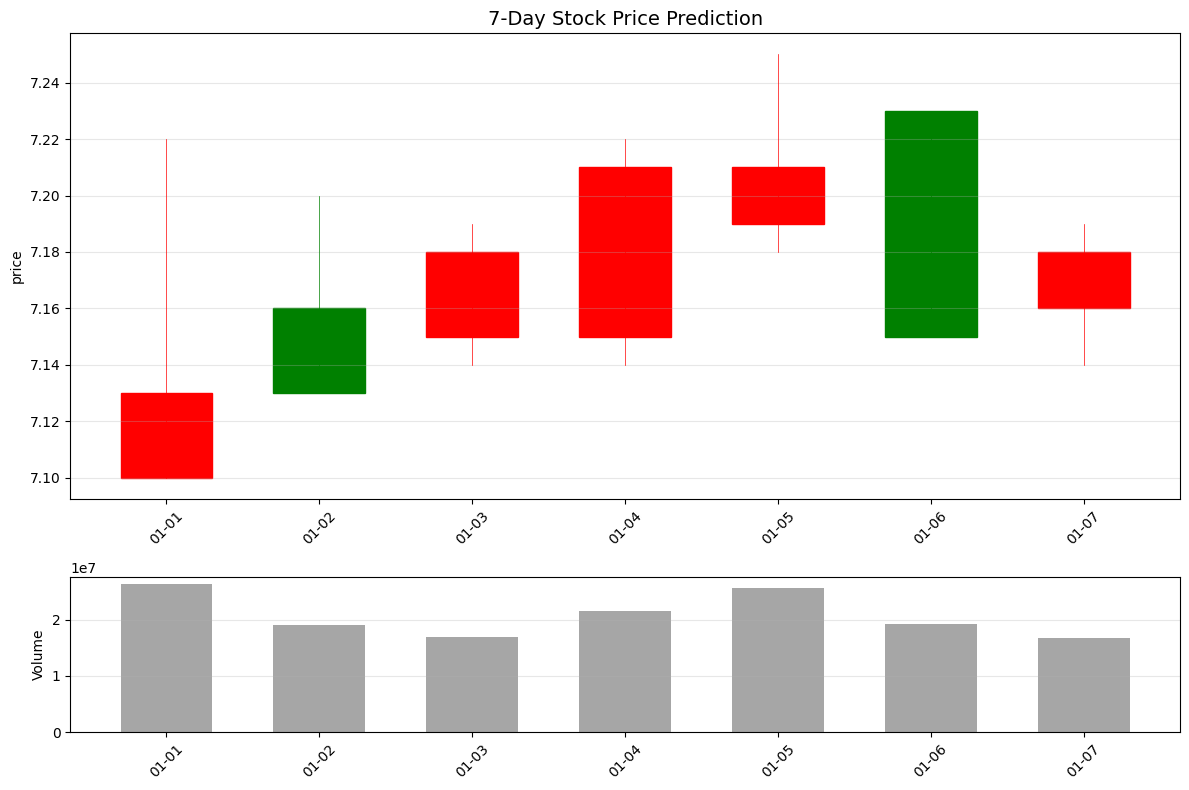

[[ 7.0999999e+00  7.2199993e+00  7.0999999e+00  7.1300001e+00
   2.6292168e+07  1.8854618e+08  8.9599997e-02  2.8130001e-01]
 [ 7.1600003e+00  7.2000003e+00  7.1300001e+00  7.1300001e+00
   1.8977676e+07  1.3579824e+08  6.4700000e-02  0.0000000e+00]
 [ 7.1499996e+00  7.1900001e+00  7.1399999e+00  7.1799998e+00
   1.6988390e+07  1.2179935e+08  5.7900000e-02  7.0130002e-01]
 [ 7.1499996e+00  7.2199993e+00  7.1399999e+00  7.2100000e+00
   2.1506286e+07  1.5465696e+08  7.3299997e-02  4.1780001e-01]
 [ 7.1900001e+00  7.2500000e+00  7.1799998e+00  7.2100000e+00
   2.5687814e+07  1.8547792e+08  8.7499999e-02  0.0000000e+00]
 [ 7.2300005e+00  7.2300005e+00  7.1499996e+00  7.1499996e+00
   1.9141408e+07  1.3729446e+08  6.5200001e-02 -8.3219999e-01]
 [ 7.1600003e+00  7.1900001e+00  7.1399999e+00  7.1799998e+00
   1.6641289e+07  1.1929327e+08  5.6699999e-02  4.1960001e-01]]


In [147]:
plot_kline(sample_output, start_date="2024-01-01")
print(sample_output)

警告: high < low [H=3.2695, L=3.6168]
警告: high < low [H=3.2604, L=3.6109]
警告: high < low [H=3.2612, L=3.6067]
警告: high < low [H=3.2596, L=3.6040]
警告: high < low [H=3.2549, L=3.6036]
警告: high < low [H=3.2483, L=3.6053]
警告: high < low [H=3.2430, L=3.6084]


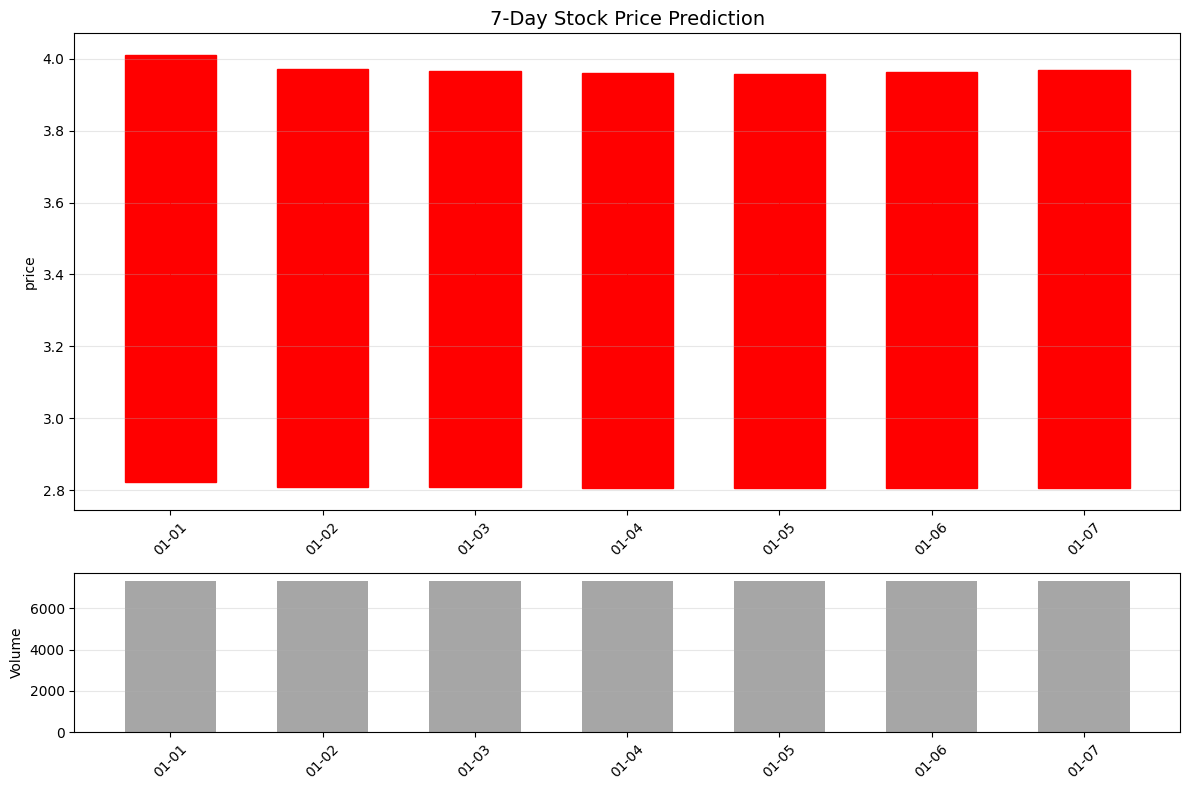

[[ 2.8222730e+00  3.2694998e+00  3.6168275e+00  4.0104213e+00
   7.3096714e+03  2.3504654e+04  6.9785066e-02 -3.5313796e-02]
 [ 2.8098357e+00  3.2604063e+00  3.6108863e+00  3.9727707e+00
   7.3339150e+03  2.3442846e+04  7.2131075e-02 -4.3859873e-02]
 [ 2.8089423e+00  3.2611632e+00  3.6067235e+00  3.9652395e+00
   7.3289292e+03  2.3467834e+04  7.1918271e-02 -4.5835104e-02]
 [ 2.8065903e+00  3.2595990e+00  3.6040480e+00  3.9594076e+00
   7.3271758e+03  2.3482047e+04  7.1024917e-02 -4.6914238e-02]
 [ 2.8048553e+00  3.2548528e+00  3.6035726e+00  3.9587188e+00
   7.3290908e+03  2.3482832e+04  6.9842495e-02 -4.5925487e-02]
 [ 2.8049846e+00  3.2483172e+00  3.6052961e+00  3.9629657e+00
   7.3340273e+03  2.3472264e+04  6.8958454e-02 -4.3114163e-02]
 [ 2.8072278e+00  3.2429857e+00  3.6084354e+00  3.9688106e+00
   7.3399038e+03  2.3456510e+04  6.8821691e-02 -3.9861500e-02]]


In [148]:
plot_kline(predictions, start_date="2024-01-01")
print(predictions)